# Visualization of Targeter Chemical Cross-Linking Data

A supplement Notebook for producing plots related to **Identification of Protective Antibodies using _in silico_ Protein Docking coupled with Targeted Chemical Cross-Linking Mass Spectrometry**.

---

## Index

- [Notebook instructions](#notebook-instructions)
- [Packages](#packages)
  - [Descriptions](#descriptions)
  - [Imports](#imports)
- [Variables](#variables)
- [Functions](#functions)
- [Analysis](#analysis)
  - [Cross-linking summary](#cross-linking-summary)
  - [Structural analysis](#structural-analysis)

---

## Notebook instructions

There are two dropdown menus in this Notebook that allow for user input. [The first one](#subset-selection-receiver) sets the antigen of interest (for a cursory look), [while the second](#subset-selection-ligand) sets the antibody to perform further structural analysis on. If `run all` was executed initially, change the menu option and select `run below` from the subsequent code box.

## Packages

### Descriptions

#### Package

_Reason for inclusion_: TBD

### Imports

In [1]:
# Package imports:
import math
import pickle
import sqlite3 as sql
from pathlib import Path

import matplotlib.pyplot as plt
import nglview as nv
import ipywidgets as widgets
import py3Dmol as p3m
import pandas as pd
import seaborn as sns
from Bio import SeqIO
from Bio.PDB import PDBParser, PPBuilder
from matplotlib.ticker import StrMethodFormatter
from matplotlib_inline import backend_inline
from pandas import DataFrame

backend_inline.set_matplotlib_formats('svg')
sns.set_theme(style="whitegrid")

## Variables

To not crowd the notebook with uninteresting code, some variables are stored in `.pkl` files and imported below at runtime.

In [2]:
# Variable imports:
with open('vars/aa_3to1.pkl', 'rb') as f:

    aa_3to1 = pickle.load(f)

## Functions

In [3]:
# Function definitions:
def sql_to_df(db_file: Path, query: str = 'SELECT * FROM MS2data') -> DataFrame:

    con = sql.connect(db_file)

    return pd.read_sql(query, con)

## Analysis

Bla bla bla, antigen of interest, epitope, receiver, etc.

### **( ! )** Subset selection: receiver

Select antigen (receiver) of interest in the below dropdown. To rerun the analysis with a different antigen select a new item in the dropdown, and rerun the cells below the input box.

In [4]:
# Display dropdown to enable data subset selection.
receivers = [p.name for p in Path('data').resolve().glob('*')]

receivers.sort()

receiver_subset = widgets.Dropdown(options=receivers,
                                   value=receivers[0],
                                   description='Receiver:', disabled=False)

display(receiver_subset)

Dropdown(description='Receiver:', options=('m1-b_rep', 'm1-c_rep'), value='m1-b_rep')

### Cross-linking summary

For the selected receiver (antigen).

In [5]:
receiver = receiver_subset.value

base_dir = Path(f'data/{receiver}').resolve()

if not base_dir.is_dir():

    text = f'The requested directory "{base_dir}" does not exist.'

    raise FileNotFoundError(text)

ligands = tuple((path.name for path in base_dir.iterdir()))

In [6]:
db_file = 'ms2_results.sql'

df = pd.concat({receiver:
                pd.concat({ligand:
                           sql_to_df(db_file=base_dir / ligand / db_file)
                           for ligand in ligands}, axis=0)}, axis=0)

theoretical_xls = {}

supported_xls = {}

counts = {'ligand': [], 'n_theoretical_xls': [], 'n_supported_xls': []}

for ligand in ligands:

    ms2_xls = df.loc[(receiver,), 'XL'][ligand].tolist()

    top_xls = !cat {base_dir / ligand / 'top_xls.txt'}

    theoretical_xls[ligand] = ms2_xls

    supported_xls[ligand] = top_xls

    counts['ligand'].append(ligand)

    counts['n_theoretical_xls'].append(len(ms2_xls))

    counts['n_supported_xls'].append(len(top_xls))

counts_df = pd.DataFrame.from_dict(counts)

counts_df.sort_values(by='n_theoretical_xls', ascending=False, inplace=True)

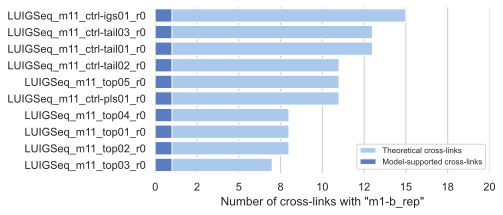

In [7]:
f, ax = plt.subplots(figsize=(6, 3))

sns.set_color_codes("pastel")

sns.barplot(x="n_theoretical_xls", y="ligand", data=counts_df,
            label="Theoretical cross-links", color="b")

sns.set_color_codes("muted")

sns.barplot(x="n_supported_xls", y="ligand", data=counts_df,
            label="Model-supported cross-links", color="b")

rounded_max = math.ceil(counts_df.iloc[:, 1].values.max()/10)*10

ax.legend(ncol=1, loc="lower right", frameon=True, fontsize=8)

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

ax.set(xlim=(0, rounded_max),
       ylabel='', xlabel=f'Number of cross-links with "{receiver}"')

sns.despine(left=True, bottom=True)

### **( ! )** Subset selection: ligand

Select antibody Fab (ligand) of interest in the below dropdown. To rerun the analysis with a different Fab select a new item in the dropdown, and rerun the cells below the input box.

In [8]:
# Display dropdown to enable data subset selection.
top_ligand = counts_df.loc[counts_df['n_theoretical_xls'].idxmax()]['ligand']
ligand_subset = widgets.Dropdown(options=ligands,
                               value=top_ligand,
                               description='Ligand:',
                               disabled=False)
display(ligand_subset)

Dropdown(description='Ligand:', index=5, options=('LUIGSeq_m11_ctrl-tail03_r0', 'LUIGSeq_m11_top04_r0', 'LUIGS…

### Structural analysis

Of the selected ligand (antibody).

In [9]:
ligand = ligand_subset.value

tmp_pdb = base_dir / ligand / 'best_model.pdb'

parser = PDBParser()

tmp_structure = parser.get_structure(f'{receiver}--{ligand}', tmp_pdb)

tmp_model = tmp_structure[0]

polypeptides = []

for record in SeqIO.parse(base_dir / ligand / 'input.fasta', 'fasta'):

    polypeptides.append(str(record.seq))

sequence = ''

for chain in tmp_model:

    seq = []

    for res in chain:

        seq.append(aa_3to1[res.resname])

    sequence += ''.join(seq)

search_sequence = str(sequence)

pp_indexes = []

for pp in polypeptides:

    while search_sequence.find(pp) > -1:

        idx_start = search_sequence.find(pp)

        idx_full = [idx_start + 1, idx_start + len(pp)]

        search_sequence = search_sequence.replace(pp, '-' * len(pp), 1)

        pp_indexes.append((idx_full, pp))

pp_indexes.sort()

In [10]:
pdb = base_dir / ligand / 'best_model_corr.pdb'

abc = 'ABCDEFG'

assigned_chains = []

pdb_edit = base_dir / ligand / 'edit.pdb'

pdb_edit.touch()

for i, index in enumerate(pp_indexes):

    idx = f'-{index[0][0]}:{index[0][1]}'

    chain = f'-{abc[i]}'

    assigned_chains.append(abc[i])

    !pdb_selres {idx} {tmp_pdb} | pdb_chain {chain} >> {pdb_edit}

!pdb_tidy {pdb_edit} | pdb_reatom > {pdb}

pdb_edit.unlink()

In [11]:
colors = ['0xff579c', '0xfde531', '0x56afdf', '0xec8248']

view = p3m.view()

view.setBackgroundColor('0xC1C1C1')

view.addModel(open(pdb,'r').read(), 'pdb')

for chain, color in zip(assigned_chains, colors):

    view.setStyle({'chain': chain}, {'cartoon': {'color': color}})

In [12]:
ligand_ms2_xls = df.loc[(receiver, ligand), 'XL']

ligand_model_xls = df.loc[(receiver, ligand),
                          :].query(f'XL in {top_xls}').loc[:, 'XL']

_Adding the cross-links to the model turned out to be a non-trivial task that I couldn't complete within the allotted time-frame. For now, there is only the basic visualization of the predicted and docked proteins._

In [13]:
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [14]:
view = p3m.view(pdb,
                viewergrid=(1, 2),
                style=[[{'stick':{'colorscheme':'greenCarbon'}},
                        {'cartoon':{'color':'spectrum'}, 'stick': {}}]])

view.setBackgroundColor('0xC1C1C1')

view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol